In [81]:
import pandas as pd
import numpy as np

struct_data = pd.DataFrame()
df = pd.read_csv(r".\问题\data_from_web.csv")
df['p1_score'] = df['p1_score'].apply(lambda x: 50 if 'AD' in x else x).astype(int)
df['p2_score'] = df['p2_score'].apply(lambda x: 50 if 'AD' in x else x).astype(int)

In [82]:
df['p1_diff'] = df['p1_score'].diff()
df['p2_diff'] = df['p2_score'].diff()

# 创建 win 列
conditions = [
    df['p1_diff'] > 0,
    df['p2_diff'] > 0
]
choices = [1, 2]

df['win'] = np.select(conditions, choices, default=0)

# 可选：删除中间的差分列
df.drop(['p1_diff', 'p2_diff'], axis=1, inplace=True)

conditions = [
    (df['win'] == 0) & (df['p1_score'] > df['p2_score']),  # p1_score 大于 p2_score
    (df['win'] == 0) & (df['p1_score'] < df['p2_score']),  # p1_score 小于 p2_score
]

# 对应条件的值
choices = [
    1,  # p1_score 大时赋值为 1
    2,  # p2_score 大时赋值为 2
]

# 使用 np.select 更新 'win' 列
df['win'] = np.select(conditions, choices, default=df['win'])

In [83]:
import math

struct_data["win"] = df['win']

ws = 6
windows1 = df['win'].apply(lambda x: 1 if x == 1 else 0).astype(int).copy().rolling(window=ws)
times_mean = windows1.mean()
struct_data["win1_mean"] = times_mean
windows2 = df['win'].apply(lambda x: 1 if x == 2 else 0).astype(int).copy().rolling(window=ws)
times_mean = windows2.mean()
struct_data["win1_mean"] = times_mean
struct_data["unf_err"] = df["p1_unf_err"] - df["p2_unf_err"]
struct_data["ace"] = df["p1_ace"] - df["p2_ace"]
struct_data["net_pt"] = 0
struct_data["winner"] = df["p1_winner"] - df["p1_winner"]
struct_data["net_pt_won"] = struct_data["winner"]
struct_data["double_fault"] = struct_data["unf_err"]
struct_data["break_pt_won"] = struct_data["ace"]
struct_data["break_pt_missed"] = struct_data["unf_err"]
struct_data["server"] = 0
struct_data["run"] = math.log2(6)-1

struct_data["all_win"] = 0
for i in range(5):
    window = df["win"].copy()
    window[window == 2] = -1
    window = window.rolling(window=(i+1))
    times_mean = window.mean()
    apply_result = times_mean.apply(lambda x: (i+1) if x == 1 else 0)
    struct_data["all_win"] = np.maximum(apply_result, struct_data["all_win"])
    
struct_data.drop(["win"], axis=1, inplace=True)

In [84]:

struct_data = pd.read_csv(r".\out_data_modify.csv")
new_col = ['ace', 'winner', 'double_fault', 'unf_err', 'break_pt_won',
       'break_pt_missed', 'net_pt', 'net_pt_won', 'server', 'run', 'all_win',
       'win1_mean']
struct_data = struct_data[new_col]
struct_data

,ace,winner,double_fault,unf_err,break_pt_won,break_pt_missed,net_pt,net_pt_won,server,run,all_win,win1_mean
0,0,0,0,0,0,0,0,0,0,0,0,0.500000
1,0,0,-1,-1,0,-1,0,0,0,0,0,0.000000
2,0,0,1,1,0,1,0,0,0,0,1,0.500000
3,0,0,0,0,0,0,0,0,0,0,0,0.333333
4,0,0,-1,-1,0,-1,0,0,0,0,1,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
120,0,0,1,1,0,1,0,0,0,0,1,0.500000
121,0,0,1,1,0,1,0,0,0,0,2,0.333333
122,0,0,1,1,0,1,0,0,0,0,3,0.333333
123,0,0,0,0,0,0,0,0,0,0,4,0.166667


In [85]:
from NetWorkPackage.MLP import MLP
from NetWorkPackage.Transformer import TransformerDecoder, TransformerDecoderLayer, generate_square_subsequent_mask
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn 
import torch.optim as optim
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


layer = TransformerDecoderLayer(12, 3, 100, 0.1, normalize_before=True).to("cuda:0")
model = TransformerDecoder(layer, 1)
state_dict = torch.load('model_state_dict.pth')
model.load_state_dict(state_dict)
model.eval()

data = torch.from_numpy(struct_data.values).unsqueeze(0).to(torch.float32)

model.train()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5

def get_window(batch_size, seq_len, step):
    mask = torch.zeros(batch_size, seq_len, dtype=torch.bool)  # 初始化一个全False的遮罩
    for i in range(step, seq_len, step):
        mask[:, i:min(i+step, seq_len)] = True  # 在每个步长区间设置True
    return mask

idata = data.clone()

all_res = []
all_val = []

itdata = data.permute(1,0,2).to("cuda:0")
tgt = data.permute(1,0,2).to("cuda:0")
# 前向传播
outputs = model(memory=itdata, tgt=tgt, tgt_mask=generate_square_subsequent_mask(len(tgt)).to(tgt.device))

outputs = outputs.permute(1,0,2)[0,:,-1].cpu()
val_data = tgt.permute(1,0,2)[0,:,-1].cpu()

ss_res = np.sum((outputs.detach().numpy() - val_data.detach().numpy()) ** 2)  # 残差平方和
ss_tot = np.sum((outputs.detach().numpy() - np.mean(val_data.detach().numpy())) ** 2)  # 总平方和
r_squared = 1 - (ss_res / ss_tot)

res = outputs > 0.5
val = val_data > 0.5
all_res.append(outputs)
acc = (res==val).sum()/val.shape[0]

mse = np.mean((outputs.detach().numpy() - val_data.detach().numpy()) ** 2)
rmse = np.sqrt(mse)
recall = recall_score(val, res)
precision = precision_score(val, res)
all_val.append([r_squared, acc.item(), rmse, recall, precision])

for i in range(5):
    state_dict = torch.load('model_state_dict.pth')
    model.load_state_dict(state_dict)
    n = int(data.shape[1]*(0.1*(i+1)))
    for epoch in range(num_epochs):  # num_epochs 是你希望训练的轮数
        indata = idata[:,:n].permute(1,0,2).to("cuda:0")
        tgt = idata[:,:n].permute(1,0,2).to("cuda:0")
        # 前向传播
        outputs = model(memory=indata, tgt=tgt, tgt_mask=generate_square_subsequent_mask(len(tgt)).to(tgt.device))
        print(outputs.shape)
        loss = criterion(outputs, idata[:,1:n+1].to("cuda:0"))
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()


    itdata = data.permute(1,0,2).to("cuda:0")
    tgt = data.permute(1,0,2).to("cuda:0")
    # 前向传播
    outputs = model(memory=itdata, tgt=tgt, tgt_mask=generate_square_subsequent_mask(len(tgt)).to(tgt.device))

    outputs = outputs.permute(1,0,2)[0,:,-1].cpu()
    val_data = tgt.permute(1,0,2)[0,:,-1].cpu()

    ss_res = np.sum((outputs.detach().numpy() - val_data.detach().numpy()) ** 2)  # 残差平方和
    ss_tot = np.sum((outputs.detach().numpy() - np.mean(val_data.detach().numpy())) ** 2)  # 总平方和
    r_squared = 1 - (ss_res / ss_tot)

    res = outputs > 0.5
    val = val_data > 0.5
    all_res.append(outputs)
    acc = (res==val).sum()/val.shape[0]
    
    mse = np.mean((outputs.detach().numpy() - val_data.detach().numpy()) ** 2)
    rmse = np.sqrt(mse)
    
    recall = recall_score(val, res)
    precision = precision_score(val, res)
    all_val.append([r_squared, acc.item(), rmse, recall, precision])

torch.Size([12, 1, 12])
torch.Size([12, 1, 12])
torch.Size([12, 1, 12])
torch.Size([12, 1, 12])
torch.Size([12, 1, 12])
torch.Size([25, 1, 12])
torch.Size([25, 1, 12])
torch.Size([25, 1, 12])
torch.Size([25, 1, 12])


d:\Miniconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 12, 12])) that is different to the input size (torch.Size([12, 1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Miniconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 25, 12])) that is different to the input size (torch.Size([25, 1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([25, 1, 12])
torch.Size([37, 1, 12])
torch.Size([37, 1, 12])
torch.Size([37, 1, 12])
torch.Size([37, 1, 12])
torch.Size([37, 1, 12])
torch.Size([50, 1, 12])
torch.Size([50, 1, 12])
torch.Size([50, 1, 12])
torch.Size([50, 1, 12])
torch.Size([50, 1, 12])
torch.Size([62, 1, 12])
torch.Size([62, 1, 12])
torch.Size([62, 1, 12])
torch.Size([62, 1, 12])
torch.Size([62, 1, 12])


d:\Miniconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 37, 12])) that is different to the input size (torch.Size([37, 1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Miniconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 50, 12])) that is different to the input size (torch.Size([50, 1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Miniconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 62, 12])) that is different to the input size (torch.Size([62, 1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(

In [86]:
all_val = np.array(all_val).T
all_val = all_val.tolist()


In [87]:
all_val

[[0.23337632417678833,
  0.2595929503440857,
  0.2651129961013794,
  0.29178136587142944,
  0.26893842220306396,
  0.262304425239563],
 [0.9039999842643738,
  0.8880000114440918,
  0.8560000061988831,
  0.9359999895095825,
  0.8799999952316284,
  0.8799999952316284],
 [0.30474168062210083,
  0.26528799533843994,
  0.2631067931652069,
  0.2661493718624115,
  0.265733927488327,
  0.2649415135383606],
 [0.625, 0.5, 0.4375, 0.625, 0.5, 0.5625],
 [0.625,
  0.5714285714285714,
  0.4375,
  0.8333333333333334,
  0.5333333333333333,
  0.5294117647058824]]

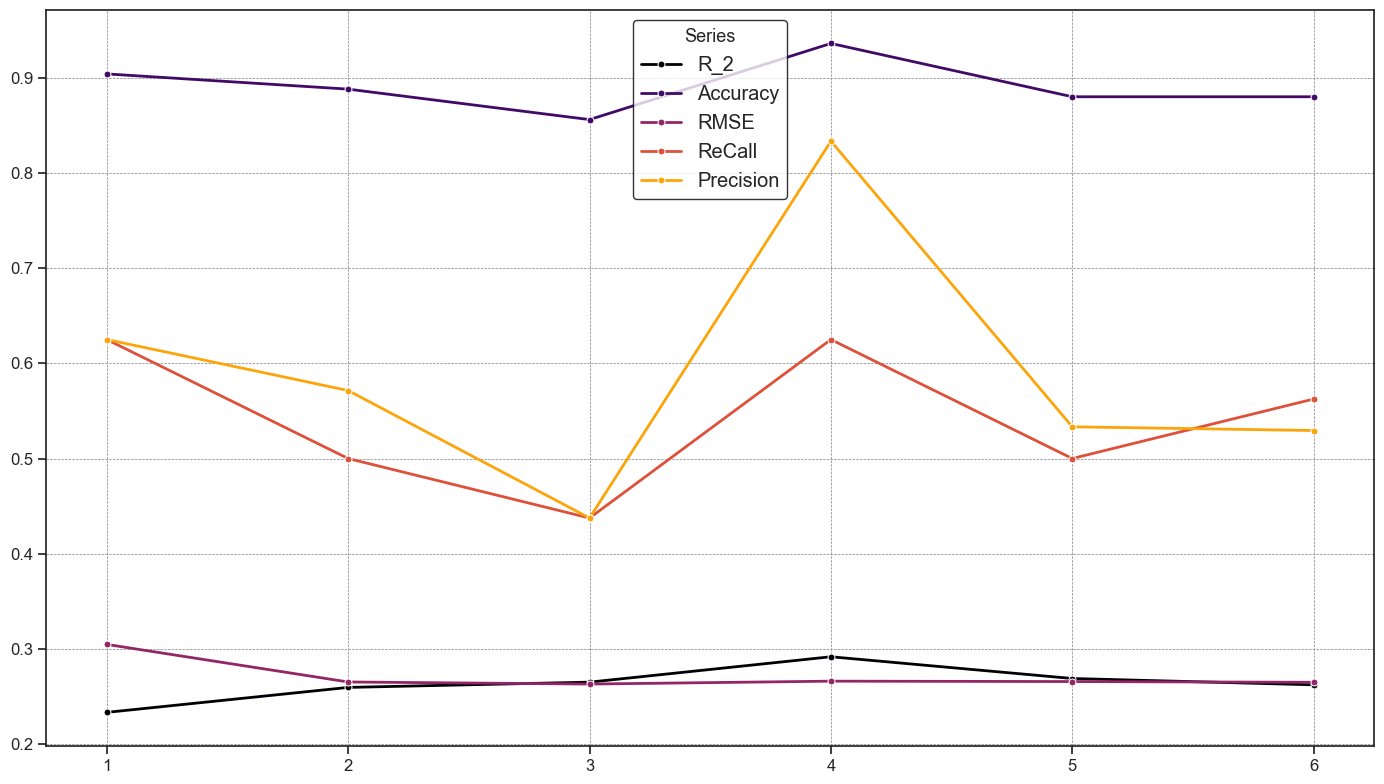

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from matplotlib.cm import get_cmap

sns.set_theme(style="ticks")
x2 = np.arange(1, 7)

fig, ax1 = plt.subplots(figsize=(14, 8))
ax1.grid(color='gray', linestyle='--', linewidth=0.5)

n = len(all_val)
value_label = ["R_2", "Accuracy", "RMSE", "ReCall", "Precision"]
color_map = get_cmap('inferno')  # 选择一个colormap
colors = [color_map(i/n) for i in range(n)]  # 生成渐变颜色列表

idx = 0
for color, i in zip(colors, all_val):
    sns.lineplot(x=x2, y=i, ax=ax1, marker='o', linestyle='-', color=color, label=value_label[idx], linewidth=2, markersize=5)
    idx += 1
# 蓝色 #4169E1 橙色 FFA400  绿#6C935C
# sns.lineplot(x=x, y=sydata, ax=ax1, marker='o', linestyle='-', color='#4169E1', label='Actual Data', linewidth=2, markersize=5)
# plt.fill_between(range(len(y_pred)), lower_bounds, upper_bounds, color='#FF7500', alpha=0.2, label='Predicted Range')
# sns.lineplot(x=x, y=st, ax=ax1, marker='o', linestyle='-', color='#6C935C', label='Actual Data', linewidth=2, markersize=5)

# 优化标题和轴标签的字体大小和样式
# ax1.set_title('Line Plot with Continuous Distribution Heatmap', fontsize=20, fontweight='bold')
# ax1.set_xlabel('Score points', fontsize=14, fontweight='bold')
# ax1.set_ylabel('Probability of winning', fontsize=14, fontweight='bold')

# 调整Y轴范围以拉大展示大小
# y_min = min(min(sydata), min(sy_pred)) - 0.4   # 略微下调最小值
# y_max = max(max(sydata), max(sy_pred)) *1.5  # 略微上调最大值
# ax1.set_ylim([y_min, y_max])

# 设置刻度标签的大小
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

# 美化图例
legend = ax1.legend(frameon = True, loc='best', fontsize='large', title='Series', title_fontsize='13', edgecolor='black')
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv(r".\england-premier-league-matches-2018-to-2019-stats.csv")

df = df[(df["home_team_name"] == "Manchester United")]

In [118]:
struct_new_data = pd.DataFrame()
struct_new_data["pre_math"] = df["Pre-Match PPG (Home)"].astype(float) - df["Pre-Match PPG (Away)"].astype(float)
struct_new_data["ppg"] = df["home_ppg"] - df["away_ppg"]
struct_new_data["team_goal_count"] = df["home_team_goal_count"] - df["away_team_goal_count"]
struct_new_data["team_fouls"] = -df["home_team_fouls"] + df["away_team_fouls"]
struct_new_data["team_possession"] = df["home_team_possession"] - df["away_team_possession"]
struct_new_data["team_goal_count_half_time"] = df["home_team_goal_count_half_time"] - df["away_team_goal_count_half_time"]
struct_new_data["team_corner_count"] = df["home_team_corner_count"] - df["away_team_corner_count"]
struct_new_data["team_shots_on_target"] = df["home_team_shots_on_target"] - df["away_team_shots_on_target"]
struct_new_data["team_shots_off_target"] = -df["home_team_shots_off_target"] + df["away_team_shots_off_target"]
struct_new_data["team_possession"] = df["home_team_possession"] - df["away_team_possession"]
struct_new_data["btts_percentage_pre_match"] = df["btts_percentage_pre_match"]
struct_new_data["team_red_cards"] = -df["home_team_red_cards"]+df["away_team_red_cards"]
struct_new_data["prob"] = df["team_a_xg"]/(df["team_a_xg"]+df["team_b_xg"])

input_tensor = struct_new_data.values
input_tensor = (input_tensor -input_tensor.mean(axis=0)) / input_tensor.std(axis=0)
input_tensor.shape

(19, 12)

In [120]:
layer = TransformerDecoderLayer(12, 3, 100, 0.1, normalize_before=True).to("cuda:0")
model = TransformerDecoder(layer, 1)
state_dict = torch.load('model_state_dict.pth')
model.load_state_dict(state_dict)
model.eval()

data = torch.from_numpy(input_tensor).unsqueeze(0).to(torch.float32)
itdata = data.permute(1,0,2).to("cuda:0")
tgt = data.permute(1,0,2).to("cuda:0")
# 前向传播
outputs = model(memory=itdata, tgt=tgt, tgt_mask=generate_square_subsequent_mask(len(tgt)).to(tgt.device))

outputs = outputs.permute(1,0,2)[0,:,-1].cpu()
val_data = tgt.permute(1,0,2)[0,:,-1].cpu()

ss_res = np.sum((outputs.detach().numpy() - val_data.detach().numpy()) ** 2)  # 残差平方和
ss_tot = np.sum((outputs.detach().numpy() - np.mean(val_data.detach().numpy())) ** 2)  # 总平方和
r_squared = 1 - (ss_res / ss_tot)

res = outputs > 0.5
val = val_data > 0.5
all_res.append(outputs)
acc = (res==val).sum()/val.shape[0]

In [121]:
acc, 

(tensor(0.9474),
 tensor([False,  True, False, False, False, False, False,  True,  True,  True,
          True,  True, False,  True, False, False, False, False,  True]))